# Regressing lane lines

In [117]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.path.append("..")

%autoreload 2
from pipeline import LaneColorMasking, EdgeDetection
from scripts.processing import undistort_and_warp, build_roi_mask
from scripts.channels import show_single_image, show_two_images
from scripts.conversion import bgr2lab
roi_mask = build_roi_mask()

In [5]:
friendly_paths = glob.glob(os.path.join('..', 'test_images', 'test*.jpg'))
hard_paths = glob.glob(os.path.join('..', 'test_images', 'challenge*.jpg'))
len(friendly_paths), len(hard_paths)

(6, 9)

In [7]:
def get_test_image(i: int, resize: bool=True, hard: bool=True) -> np.ndarray:
    img = cv2.imread(hard_paths[i] if hard else friendly_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (0, 0), fx=0.25, fy=0.25) if resize else img

First we define the edge and color detection instances:

In [104]:
edg = EdgeDetection(detect_lines=False, mask=roi_mask)
edg.filter_threshold = .03

lcm = LaneColorMasking()
lcm.detect_lines = False
lcm.blue_threshold = 25
lcm.light_cutoff = .9

Then we obtain and combine the masks.

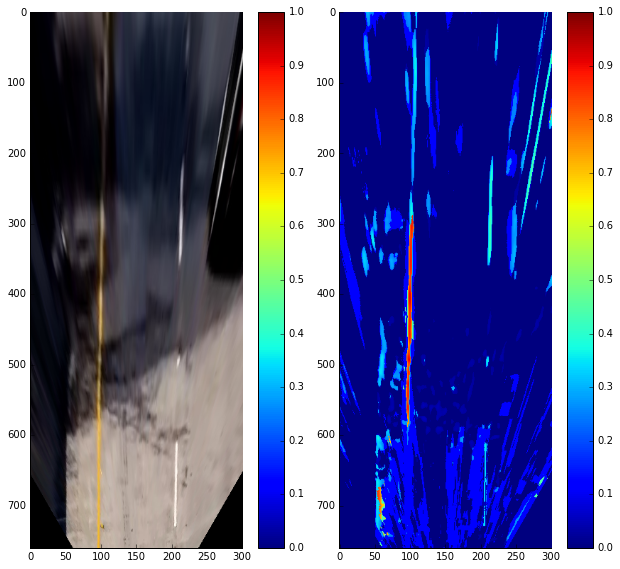

In [240]:
def get_mask(frame: np.ndarray, edg: EdgeDetection, lcm: LaneColorMasking, additive: bool=True) -> np.ndarray:
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    mask_l, mask_b = lcm.process(lab, is_lab=True)
    if additive:
        filtered = edg.filter(lab, is_lab=True)
        mask_sum = np.float32(filtered) / filtered.max()
        mask_sum += np.float32(mask_l) / 255.
        mask_sum += np.float32(mask_b) / 255.
        return (mask_sum / 3) ** 2
    edges = edg.detect(lab, is_lab=True)
    mask_le = mask_l & edges
    mask_be = mask_b & edges
    mask_lb = mask_l & mask_b
    mask = mask_lb | mask_le | mask_be
    return mask

test_img = get_test_image(0, resize=False, hard=False)
warped = undistort_and_warp(test_img)
mask = get_mask(warped, edg, lcm)
show_two_images(warped, mask, vmin=0, vmax=1, cmap='jet', colorbar=True)

## Initialization of search with the additive mask

One simple approach of generating lane line assumptions is to obtain actual line segments / points e.g. via the Hough transform, then using RANSAC to obtain and/or discard matching lanes.

In this approach, we're performing a simple search from the bottom of the frame up in order to then regress a spline.

First, we're starting at a friendly location where we know lane lines exist.

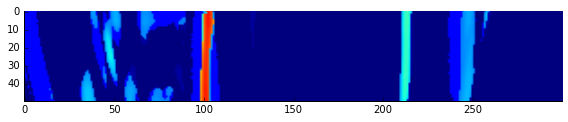

In [274]:
window_nice = mask[300:350, ...]
show_single_image(window_nice, cmap='jet', vmin=0, vmax=1)

In [284]:
def build_histogram(window: np.ndarray, binwidth: int=20, binstep: int=20) -> np.ndarray:
    half_binwidth = binwidth // 2
    bins = np.uint32(np.arange(half_binwidth, window.shape[1] - half_binwidth, binstep))
    histogram = np.zeros(shape=len(bins), dtype=np.float32)
    for i, x in enumerate(bins):
        left = max(x - half_binwidth, 0)
        right = min(x + half_binwidth, window.shape[1])
        bin_area = window.shape[0] * (right - left)
        histogram[i] = np.sum(window[:, left:right]) / bin_area
    return histogram, bins

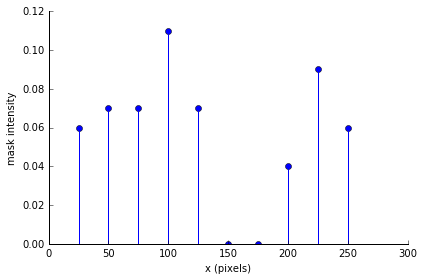

In [283]:
def plot_histogram(histogram: np.ndarray, bins: np.ndarray):
    plt.stem(bins, histogram)
    plt.xlim([0, search_initialization.shape[1]])
    plt.xlabel('x (pixels)')
    plt.ylabel('mask intensity')
    plt.tight_layout()
    sns.despine()
    
histogram_nice, bins_nice = build_histogram(window_nice, 50, 25)
plot_histogram(histogram_nice, bins_nice)

In [297]:
from typing import List

def find_maxima(histogram: np.ndarray, bins: np.ndarray, epsilon: float=0) -> List[int]:
    maxima = []
    if histogram[0] > (histogram[1] + epsilon):
        maxima.append(bins[0])
    for i in range (1, histogram.shape[0] - 1):
        left_smaller = histogram[i] > (histogram[i - 1] + epsilon)
        right_smaller = histogram[i] > (histogram[i + 1] + epsilon)
        if left_smaller and right_smaller:
            maxima.append(bins[i])
    if histogram[-1] > (histogram[-2] + epsilon):
        maxima.append(bins[-1])
    return maxima

find_maxima(histogram_nice, bins_nice)

[100, 225]

Given this, we would start our search at x=100 and x=225, which is pretty close to the truth.

However, if we start from the bottom of the image, this is what we really see:

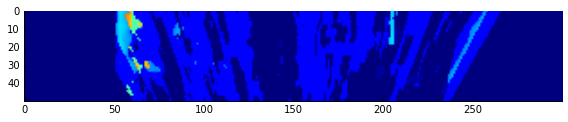

In [264]:
window_hard = mask[mask.shape[0]-50:, ...]
show_single_image(window_hard, cmap='jet', vmin=0, vmax=1)

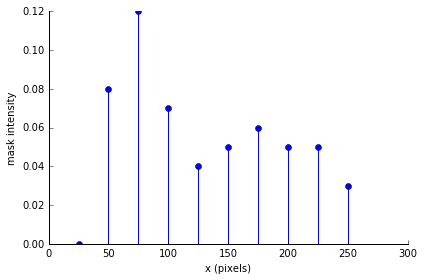

In [265]:
histogram_hard, bins_hard = build_histogram(search_initialization, 50, 25)
plot_histogram(histogram_hard, bins_hard)

In [266]:
find_maxima(histogram_hard, bins_hard)

[75, 175]

Here, the algorithm is biased to the left, were it would start at x=75 and x=175.

## Initialization from the binary mask

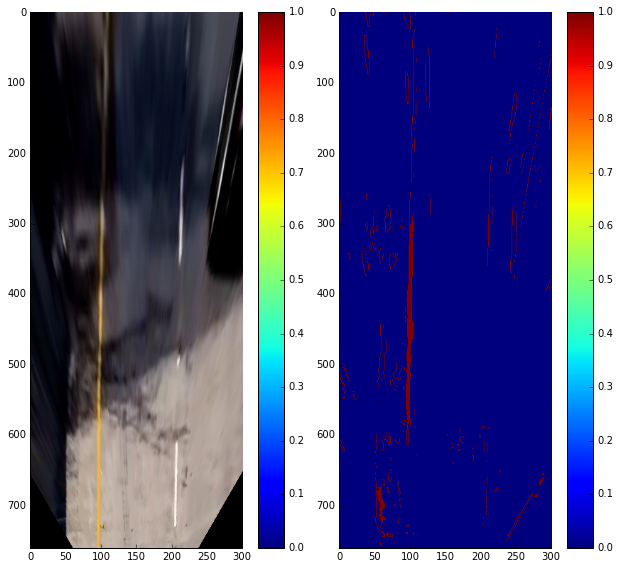

In [267]:
mask_b = get_mask(warped, edg, lcm, additive=False)
show_two_images(warped, mask_b, vmin=0, vmax=1, cmap='jet', colorbar=True)

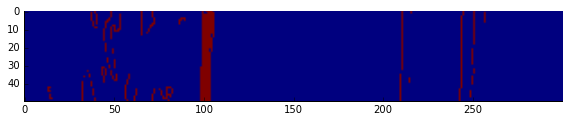

In [268]:
window_nice_b = mask_b[300:350, ...]
show_single_image(window_nice_b, cmap='jet', vmin=0, vmax=1)

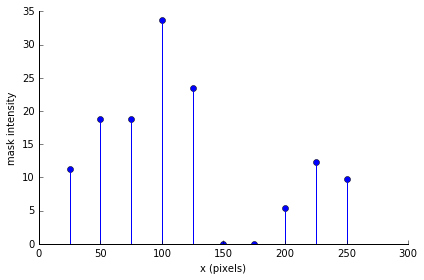

In [285]:
histogram_nice_b, bins_nice_b = build_histogram(window_nice_b, 50, 25)
plot_histogram(histogram_nice_b, bins_nice_b)

In [286]:
find_maxima(histogram_nice_b, bins_nice_b)

[50, 100, 225]

This is an interesting twist. As it turns out, the search would be initialized as x=100, x=225 and x=50. As we'll find, x=50 actually is the second-highest maximum:

In [292]:
histogram_nice_b

array([ 11.22000027,  18.87000084,  18.76799965,  33.65999985,
        23.45999908,   0.        ,   0.        ,   5.40600014,
        12.34200001,   9.79199982], dtype=float32)

We can enforce a minimum value by which a bin must be bigger than its surroundings to consider it a maximum.
This could lead to trouble, eventually.

In [299]:
find_maxima(histogram_nice_b, bins_nice_b, epsilon=0.2)

[100, 225]

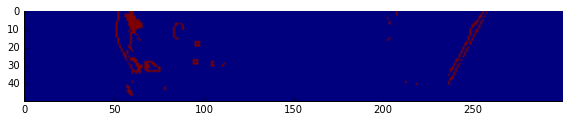

In [300]:
window_hard_b = mask_b[mask_b.shape[0]-50:, ...]
show_single_image(window_hard_b, cmap='jet', vmin=0, vmax=1)

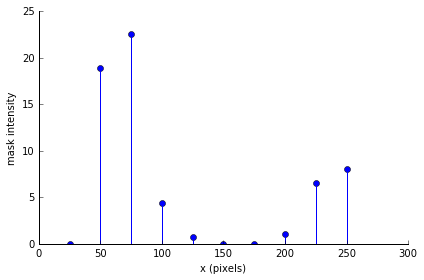

In [301]:
histogram_hard_b, bins_hard_b = build_histogram(window_hard_b, 50, 25)
plot_histogram(histogram_hard_b, bins_hard_b)

In [302]:
find_maxima(histogram_hard_b, bins_hard_b)

[75, 250]

Exactly what we expected. The x=250 estimate will eventually move the search window to the screen 
border, resulting in a valid regression, yet a severly wrong line.

With the current setup, we know that the lines are going to be positioned at x=100 and x=200, assuming the car
is driving centered on the lane, the lane widths are somewhat standard and the observed XZ plane is level (which isn't the case especially in the hard challenge video).
This means that we could run two additional searches, starting at these positions, in order to obtain 
a stable estimate even when the boundaries of the frame contain noise.

Much like non-maxima suppression was performed for finding the peaks in the histograms, we can run it 
on the search window as well. This combines the benefits of all estimates voting for the lane line, 
while still having a sharp binary mask.

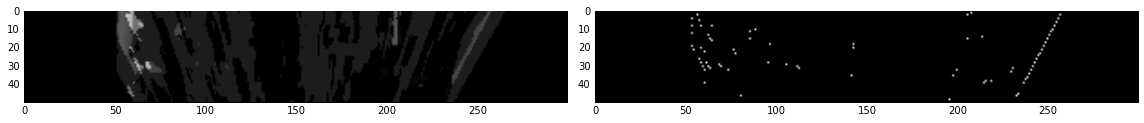

In [349]:
def window_nms(window: np.ndarray, epsilon: float=0, mode: int=0) -> np.ndarray:
    mask = np.zeros_like(window)
    for y in range(1, window.shape[0]-1):
        for x in range(1, window.shape[1]-1):
            value = window[y, x]
            sum_ = 0
            if mode == 0:
                gt_top = value > (window[y-1, x] + epsilon)
                gt_left = value > (window[y, x-1] + epsilon)
                gt_right = value > (window[y, x+1] + epsilon)
                gt_bottom = value > (window[y+1, x] + epsilon)
                if gt_top and gt_left and gt_right and gt_bottom:
                    sum_ += 1
            elif mode == 1:
                if value > (window[y-1, x] + epsilon):
                    sum_ += 0.25
                if value > (window[y, x-1] + epsilon):
                    sum_ += 0.25
                if value > (window[y, x+1] + epsilon):
                    sum_ += 0.25
                if value > (window[y+1, x] + epsilon):
                    sum_ += 0.25
            else:
                if value > (window[y-1, x-1] + epsilon):
                    sum_ += 0.125
                if value > (window[y-1, x] + epsilon):
                    sum_ += 0.125
                if value > (window[y-1, x+1] + epsilon):
                    sum_ += 0.125
                if value > (window[y, x-1] + epsilon):
                    sum_ += 0.125
                if value > (window[y, x+1] + epsilon):
                    sum_ += 0.125
                if value > (window[y+1, x-1] + epsilon):
                    sum_ += 0.125
                if value > (window[y+1, x] + epsilon):
                    sum_ += 0.125
                if value > (window[y+1, x+1] + epsilon):
                    sum_ += 0.125
            mask[y, x] = sum_
    return mask

window_hard_nms = window_nms(window_hard)
show_two_images(window_hard, window_hard_nms, vmin=0, vmax=1, cmap='gray', size=(16, 3))

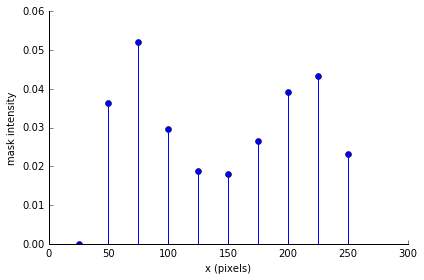

In [337]:
histogram_hard_nms, bins_hard_nms = build_histogram(window_hard_nms, 50, 25)
plot_histogram(histogram_hard_nms, bins_hard_nms)

In [339]:
find_maxima(histogram_hard_nms, bins_hard_nms)

[75, 225]

While that is still not correct for the left lane (as it cannot be), the right lane is now much closer to what we expect.

A problem with this approach is that we might be suppressing pixels that are on a plateau. An revised metric might be that the pixels mustn't be smaller than any of its surroundings yet might be the same size as the others.

The other options implement a soft version of this, where pixels are weighted according to their "maximum-ness".

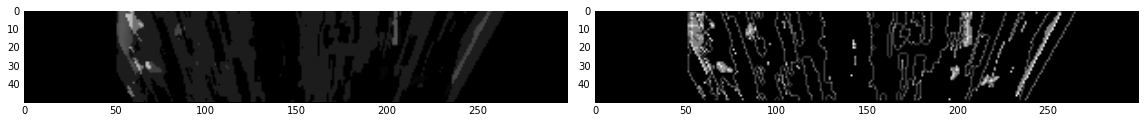

In [345]:
window_hard_nms = window_nms(window_hard, mode=1)
show_two_images(window_hard, window_hard_nms, vmin=0, vmax=1, cmap='gray', size=(16, 3))

In [346]:
histogram_hard_nms, bins_hard_nms = build_histogram(window_hard_nms, 50, 25)
find_maxima(histogram_hard_nms, bins_hard_nms)

[75, 225]

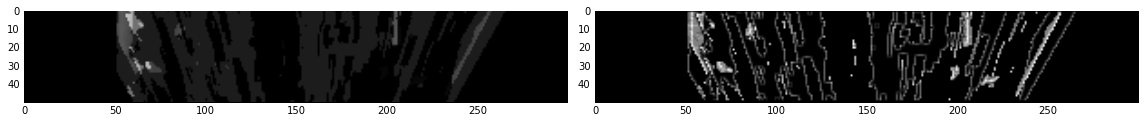

In [347]:
window_hard_nms = window_nms(window_hard, mode=2)
show_two_images(window_hard, window_hard_nms, vmin=0, vmax=1, cmap='gray', size=(16, 3))

In [348]:
histogram_hard_nms, bins_hard_nms = build_histogram(window_hard_nms, 50, 25)
find_maxima(histogram_hard_nms, bins_hard_nms)

[75, 225]